# 6.6 BONUS ARIMA Forecasting Model

#### In this script...
#### 01 Import Libraries, Data, and Cleaning
#### 02 Preparation and Exploration
#### 03 Split the data
#### 04 Set up the ARIMA Model and Evaluate the Model
#### 05 Iterate the Model
#### 06 Insights

### 01 Import Libraries, Data, and Cleaning

In [610]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

In [611]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [612]:
# Define the path

path = r'C:\Users\wallm'

In [613]:
# Using the main project data set already contains differenced time-series data

df_super = pd.read_csv(
    os.path.join(path, '01 2025 Advanced Analytics Project', 'Retail_Superstore_Project', '02 Data', 'Time_series_superstore.csv'), 
    index_col='Order Datetime')

# Ensure the index is in datetime format
df_super.index = pd.to_datetime(df_super.index)

In [614]:
df_super.shape

(1450, 1)

In [615]:
df_super.head()

,Smoothed Sales
Order Datetime,
2021-01-11,-0.930000
2021-01-12,233.267143
2021-01-13,233.267143
2021-01-14,6.060000
2021-01-15,-240.475714


In [616]:
# Set frequency to Daily

df_super.index = pd.to_datetime(df_super.index)  # Ensure the index is datetime
df_super = df_super.asfreq('D')  # Set the frequency to daily ('D')

In [617]:
# Check that the frequency

print(df_super.index.freq)

<Day>


In [618]:
df_super.columns

Index(['Smoothed Sales'], dtype='object')

In [619]:
# Check for missing values

df_super.isnull().sum()

Smoothed Sales    0
dtype: int64

In [620]:
# Look for duplicate rows and remove them if necessary

print(df_super.duplicated().sum())
df_super_diff = df_super.drop_duplicates() 

110


In [621]:
# Verify updated dataframe

print(df_super_diff.shape)
print(df_super_diff.duplicated().sum())

(1340, 1)
0


### 02 Preparation and Exploration

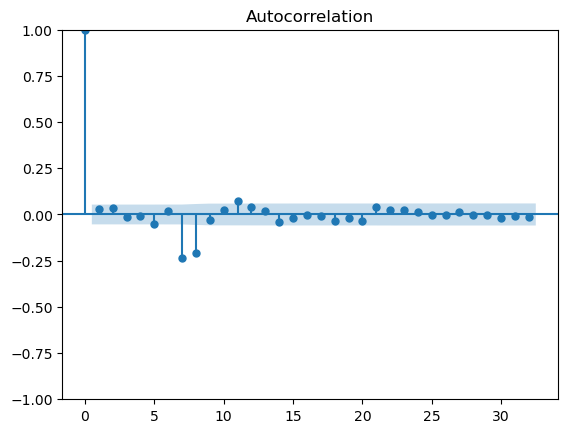

<Figure size 4500x4500 with 0 Axes>

In [623]:
# Plot autocorrelations to determine parameter q

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, this is importing the autocorrelation and partial correlation plots

plot_acf(df_super_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

##### Based on this plot, it appears that there is 2 or 3 significant spikes before the autocorrelation drops to within the confidence bounds. I will review the output from this at **q = 2**

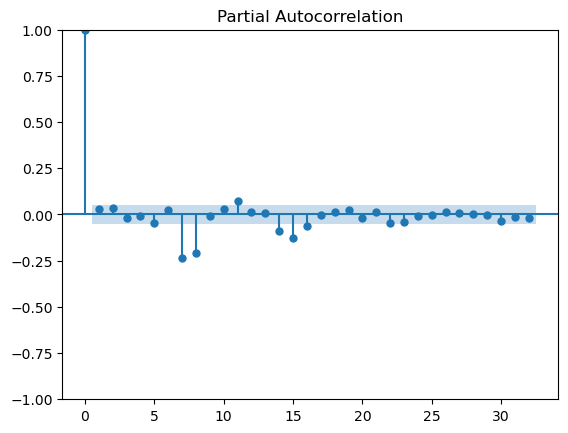

<Figure size 4500x4500 with 0 Axes>

In [625]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(df_super_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

With only 1 spike outside the confidence bounds, I'll use **p =1** (Negative spikes are not considered significant in determining the order of 
p, as they fall within the confidence intervals).

### 03 Split the data

In [628]:
#### Divide the dataset into a **training set** and a **test set** using a 70/30 split

train = df_super_diff['Smoothed Sales'][:938]
test = df_super_diff['Smoothed Sales'][937:]

In [629]:
# check that the train index retains the frequency information

print(train.index.freq)  # Should return 'D'

None


In [630]:
# Reassign frequency to the train set

train = train.asfreq('D')

In [631]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

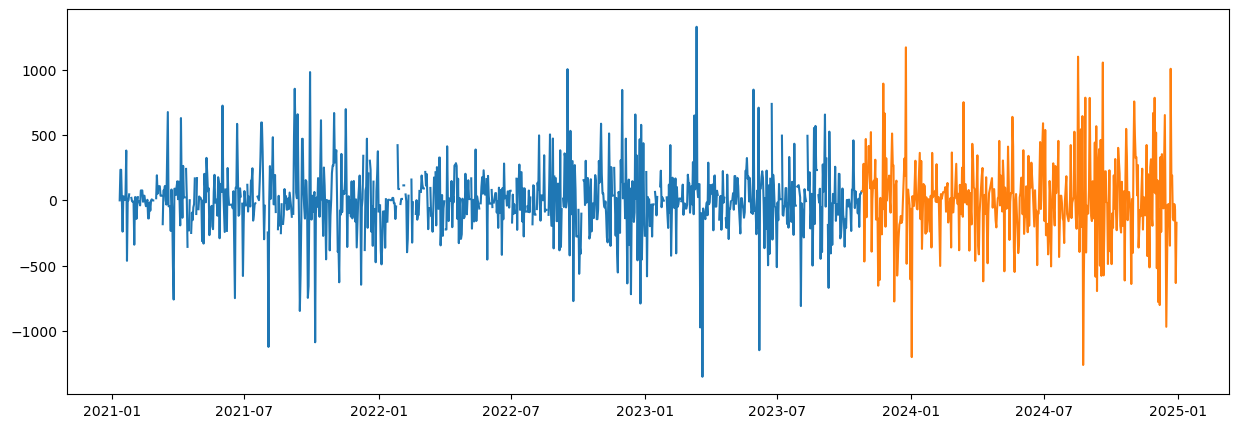

In [632]:
plt.show()

In [633]:
plt.close()

In [634]:
test.shape

(403,)

### 04 Set up the ARIMA Model

In [636]:
from statsmodels.tsa.api import ARIMA # Import the model you need

In [637]:
model = ARIMA(train, order=(1, 1, 2)) # p=1, d=1, q=2
fitted = model.fit()  
print(fitted.summary()) # Check model summary

                               SARIMAX Results                                
Dep. Variable:         Smoothed Sales   No. Observations:                 1019
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6499.480
Date:                Mon, 27 Jan 2025   AIC                          13006.960
Time:                        12:05:06   BIC                          13026.662
Sample:                    01-11-2021   HQIC                         13014.442
                         - 10-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9847      0.017    -59.168      0.000      -1.017      -0.952
ma.L1         -0.0048      0.030     -0.158      0.875      -0.064       0.055
ma.L2         -0.9952      0.028    -35.194      0.0

##### Summary shows ar.L1 and ma.L2 are statistically significant since the P-value is less than 0.05, indicating that these terms contribute meaningfully to the model. (0.000 and 0.000)

##### But, ma.L1 is not statistically significant because the P-value is greater than 0.05. (0.875)

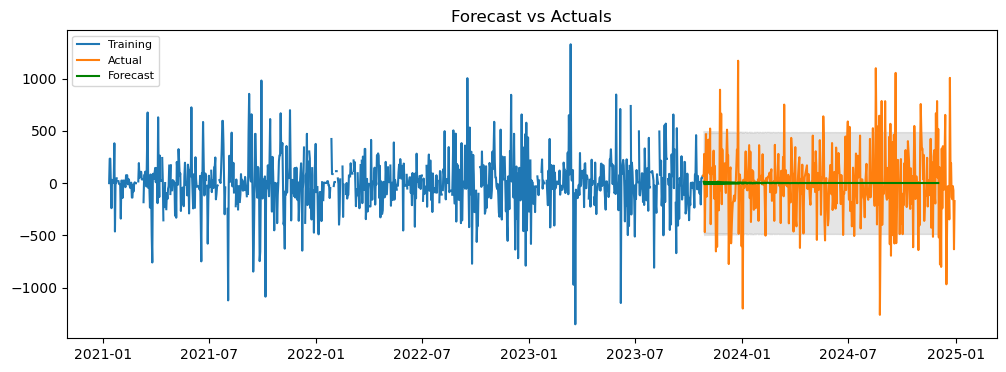

In [639]:
# Forecast

fc = fitted.forecast(steps=403)  # Returns only the forecasted values

# Create confidence intervals manually (95% CI)

conf = fitted.get_forecast(steps=403).conf_int(alpha=0.05)

# Convert to pandas series for plotting

fc_series = pd.Series(fc, index=test.index)  # Forecasted values
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)  # Lower bound
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)  # Upper bound

# Plot

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)  # CI shading
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 05 Iterate the Model

                               SARIMAX Results                                
Dep. Variable:         Smoothed Sales   No. Observations:                 1019
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6497.797
Date:                Mon, 27 Jan 2025   AIC                          13001.594
Time:                        12:05:07   BIC                          13016.371
Sample:                    01-11-2021   HQIC                         13007.205
                         - 10-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0802      0.030      2.700      0.007       0.022       0.138
ma.L1         -0.9999      0.472     -2.118      0.034      -1.925      -0.075
sigma2      6.134e+04    2.9e+04      2.117      0.0

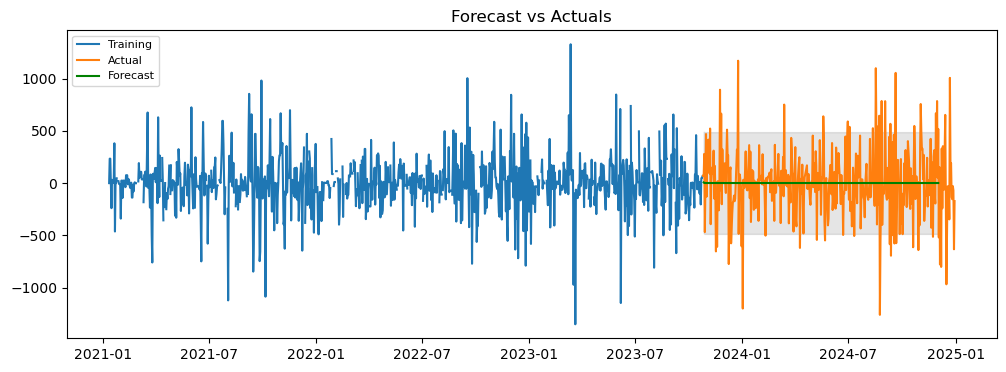

In [641]:
model = ARIMA(train, order=(1, 1, 1)) # p=1, d=1, q=1
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast

fc = fitted.forecast(steps=403)  # Returns only the forecasted values

# Create confidence intervals manually (95% CI)

conf = fitted.get_forecast(steps=403).conf_int(alpha=0.05)

# Convert to pandas series for plotting

fc_series = pd.Series(fc, index=test.index)  # Forecasted values
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)  # Lower bound
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)  # Upper bound

# Plot

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)  # CI shading
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

####  ar.L1 and ma.L1 are statistically significant based on their P-values (p < 0.05) at 0.007 and 0.034 respectively, therefore this predicting framework could be considered a successful forecasting model.

### 07 Insights

#### This model shows that the AR(1) and MA(1) terms meaningfully contribute to explaining the variance in the data.
- In iterating the model, it became more simple (ARIMA(1, 1, 1) that my original set-up, so should avoid overfitting and be easy to interpret.
- The predictions match the test data closely, and the confidence intervals seem to look appropriate, suggesting that the model performs well on unseen data.

#### For me to validate further the success of the model, I would need to:
- Ensure residuals are white noise (uncorrelated, zero-mean, constant variance).
- REF. https://otexts.com/fpp3/diagnostics.html

- This next step of verifying that residuals are white noise feels to move beyond the scope of this course, so I will conclude my analysis with the final model from the last iteration. Hence, without performing further residual diagnostics, i acknowledge the limitations of this analysis.

- Ultimately, the forecast appears to capture the general behavior of the test data, with the actuals largely falling within the confidence interval, supporting the model's effectiveness